# Car Insurance: Predicting Crash Risk for prospective customers
* https://www.tensorflow.org/neural_structured_learning

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# https://www.tensorflow.org/neural_structured_learning/install#install_neural_structured_learning_using_pip

# !pip install --upgrade neural_structured_learning

In [3]:
import neural_structured_learning as nsl

In [4]:
tf.random.set_seed(42)

In [5]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

Thu Oct 28 09:05:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.50       Driver Version: 471.21       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8    12W /  N/A |    193MiB / 16384MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import numpy as np
np.__version__

'1.19.5'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [8]:
!pip install -q dtreeviz

In [9]:
import dtreeviz
dtreeviz.__version__

'1.3'

In [10]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [11]:
from lrcurve import KerasLearningCurve

In [135]:
from typing import Tuple

import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from colour import Color
from PIL import ImageColor

from dtreeviz.colors import adjust_colors, GREY
from dtreeviz.trees import add_classifier_legend
from dtreeviz import utils


def clfviz(model, X: np.ndarray, y: np.ndarray,
           ntiles=50, tile_fraction=.9,
           binary_threshold=0.5,
           show=['instances', 'boundaries', 'probabilities', 'misclassified', 'legend'],
           feature_names=None, target_name=None, class_names=None,
           markers=None,
           boundary_marker='o', boundary_markersize=.8,
           fontsize=9, fontname="Arial",
           dot_w=25,
           yshift=.08,
           sigma=.013,
           ranges: Tuple = None,
           colors: dict = None,
           ax=None) -> None:
    """
    Two-variable case:
    Draw a tiled grid over a 2D classifier feature space where each tile is colored by
    the coordinate probabilities or coordinate predicted class. The X,y instances
    are drawn on top of the tiling. The decision boundaries are indicated
    by dots in between the classes. You can specify a threshold for the binary
    classification case. Misclassified instances are highlighted.

    One-variable case:
    Draw a strip plot over a 1D feature space, one strip per class. A narrow rectangle
    along the bottom indicates a color combined probabilities from all classes. The
    color associated with the most likely class will dominate the probabilities rectangle.
    Misclassified instances are highlighted. Decision boundaries, where the predicted
    class shifts from one to another, are indicated by vertical dashed lines.

    TODO: assumes classes are contiguous and 0..k-1

    :param model: an sklearn classifier model or any other model that can answer
                  method predict_proba(X)
    :param X: A 1- or 2-column dataframe or numpy array with the one or two features to plot
    :param y: The target column with integers indicating the true instance classes;
              currently these must be contiguous 0..k-1 for k classes.
    :param ntiles: How many tiles to draw across the x1, x2 feature space
    :param tile_fraction: A value between 0..1 indicating how much of a tile
                          should be colored; e.g., .9 indicates the tile should leave
                          10% whitespace around the colored portion.
    :param boundary_marker: The marker symbol from matplotlib to use for the boundary;
                            default is a circle 'o'.
    :param boundary_markersize: The boundary marker size; default is .8
    :param feature_names: A list of strings indicating the one or two X variable names.
                          If None, no axes labels are showing
    :param target_name: If showing legend, this is the title of the legend box.
    :param class_names: If showing legend, these are the class names in the legend box
    :param show: Which elements to show, includes elements from
                 ['instances','boundaries','probabilities','misclassified','legend']
    :param markers: By default, just small circles are shown for each X instance, but
                    if not None, this is a list of matplotlib marker strings like ['X','s'].
    :param fontsize: Font size for tick labels and axis labels
    :param fontname: The font name for  tick labels and axis labels
    :param colors: A dictionary with adjustments to the colors
    :param dot_w: How wide should the circles be when drawing the instances
    :param yshift: For univariate case. If you'd like to play around with the strip plot,
                   this variable shifts the class clusters; a shifted zero puts them on
                   top of each other.
    :param sigma:  For univariate case. The standard deviation of the noise added to make
                   the strip plot.
                   
    :param ax: An optional matplotlib "axes" upon which this method should draw. If you
               send in your own figure, it should be wide but not tall like shape 4,1
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    if len(X.shape) == 1 or (len(X.shape)==2 and X.shape[1] == 1):
        clfviz_univar(model=model, x=X, y=y,
                      ntiles=ntiles,
                      binary_threshold=binary_threshold,
                      show=show,
                      feature_name=feature_names[0] if feature_names is not None else None,
                      target_name=target_name,
                      class_names=class_names,
                      markers=markers,
                      fontsize=fontsize, fontname=fontname,
                      dot_w=dot_w,
                      sigma=sigma,
                      yshift=yshift,
                      colors=colors,
                      ax=ax)
    elif len(X.shape) == 2 and X.shape[1] == 2:
        clfviz_bivar(model=model, X=X, y=y,
                     ntiles=ntiles, tile_fraction=tile_fraction,
                     binary_threshold=binary_threshold,
                     show=show,
                     feature_names=feature_names, target_name=target_name,
                     class_names=class_names,
                     markers=markers,
                     boundary_marker=boundary_marker,
                     boundary_markersize=boundary_markersize,
                     fontsize=fontsize, fontname=fontname,
                     dot_w=dot_w, colors=colors,
                     ranges=ranges,
                     ax=ax)
    else:
        raise ValueError(f"Expecting 2D data not {X.shape}")


def clfviz_bivar(model, X:np.ndarray, y:np.ndarray,
                 ntiles=50, tile_fraction=.9,
                 binary_threshold=0.5,
                 show=['instances','boundaries','probabilities','misclassified','legend'],
                 feature_names=None, target_name=None, class_names=None,
                 markers=None,
                 boundary_marker='o', boundary_markersize=.8,
                 fontsize=9, fontname="Arial",
                 dot_w=25, colors:dict=None,
                 ranges=None,
                 ax=None) -> None:
    """
    See comment and parameter descriptions for clfviz() above.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    if len(X.shape)==1 or (len(X.shape)==2 and X.shape[1]!=2) or len(X.shape)>2:
        raise ValueError(f"Expecting 2D data not {X.shape}")

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

    # Created grid over the range of x1 and x2 variables, get probabilities, predictions
    grid_points, grid_proba, grid_pred_as_matrix, w, x_, class_X, class_values = \
        _compute_tiling(model, X, y, binary_threshold, ntiles, tile_fraction, ranges=ranges)

    x_proba = _predict_proba(model, X)
    if len(np.unique(y)) == 2:  # is k=2 binary?
        X_pred = np.where(x_proba[:, 1] >= binary_threshold, 1, 0)
    else:
        X_pred = np.argmax(x_proba, axis=1)  # TODO: assumes classes are 0..k-1
    class_X_pred = [X_pred[y == cl] for cl in class_values]

    if markers is None:
        markers = ['o']*len(class_X)

    colors = adjust_colors(colors)

    class_values = np.unique(y) # returns sorted

    # Get class to color map for probabilities and predictions
    color_map, grid_pred_colors, grid_proba_colors = \
        _get_grid_colors(grid_proba, grid_pred_as_matrix, class_values, colors)

    # Draw probabilities or class prediction grid
    facecolors = grid_proba_colors if 'probabilities' in show else grid_pred_colors
    _draw_tiles(ax, grid_points, facecolors, colors['tile_alpha'], x_, w)

    # Get grid with class predictions with coordinates (x,y)
    # e.g., y_pred[0,0] is lower left pixel and y_pred[5,5] is top-right pixel
    # for npoints=5
    grid_pred_as_matrix = grid_pred_as_matrix.reshape(ntiles, ntiles)

    if 'boundaries' in show:
        _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix,
                             boundary_marker, boundary_markersize,
                             colors, w, x_)

    # Draw the X instances circles
    if 'instances' in show:
        for i, x_ in enumerate(class_X):
            if 'misclassified' in show:
                # Show correctly classified markers
                good_x = x_[class_X_pred[i] == class_values[i],:]
                ax.scatter(good_x[:, 0], good_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)
                # Show misclassified markers (can't have alpha per marker so do in 2 calls)
                bad_x = x_[class_X_pred[i] != class_values[i],:]
                ax.scatter(bad_x[:, 0], bad_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=1.0,
                           edgecolors=colors['warning'],
                           lw=.5)
            else:
                ax.scatter(x_[:, 0], x_[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)

    if feature_names is not None:
        ax.set_xlabel(f"{feature_names[0]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])
        ax.set_ylabel(f"{feature_names[1]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])

    if 'legend' in show:
        class_names = utils._normalize_class_names(class_names, nclasses=len(class_values))
        add_classifier_legend(ax, class_names, class_values, color_map, target_name, colors,
                              fontsize=fontsize, fontname=fontname)

    ax.tick_params(axis='both', which='major', width=.3, labelcolor=colors['tick_label'],
                   labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname)
    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)


def _compute_tiling(model, X:np.ndarray, y:np.ndarray, binary_threshold,
                    ntiles, tile_fraction, ranges):
    """
    Create grid over the range of x1 and x2 variables; use the model to
    compute the probabilities with model.predict_proba(), which will work with sklearn
    and, I think, XGBoost. Later we will have to figure out how to get probabilities
    out of the other models we support.

    The predictions are computed simply by picking the argmax of probabilities, which
    assumes classes are 0..k-1. TODO: update to allow disjoint integer class values

    For k=2 binary classifications, there is no way to set the threshold and so
    a threshold of 0.5 is implicitly chosen by argmax.

    This returns all of the details needed to plot the tiles. The coordinates of
    the grid are a linear space from min to max of each variable, inclusively.
    So if the range is 1..5 and we want 5 tiles, then the width of each tile is 1.
    We get a tile at each position. When we are drawing, the position is taken as
    the center of the tile. In this case, the grid points would be centered over
    1,2,3,4, and 5.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    X1 = X[:, 0]
    X2 = X[:, 1]

    if ranges is not None:
        x1range, x2range = ranges
        min_x1, max_x1 = x1range
        min_x2, max_x2 = x2range
    else:
        min_x1, max_x1 = min(X1), max(X1) 
        min_x2, max_x2 = min(X2), max(X2)
        
    x1r = max_x1 - min_x1
    x2r = max_x2 - min_x2
    border1 = x1r*0.05 # make a 5% border
    border2 = x2r*0.05
    x1range = (min_x1-border1, max_x1+border1)
    x2range = (min_x2-border2, max_x2+border2)
    w = (x1r+2*border1) / (ntiles-1)
    h = (x2r+2*border2) / (ntiles-1)
    w *= tile_fraction
    h *= tile_fraction
    
    grid_points = []  # a list of coordinate pairs for the grid
    # Iterate through v1 (x-axis) most quickly then v2 (y-axis)
    for iv2, v2 in enumerate(np.linspace(*x2range, num=ntiles, endpoint=True)):
        for iv1, v1 in enumerate(np.linspace(*x1range, num=ntiles, endpoint=True)):
            grid_points.append([v1, v2])
    grid_points = np.array(grid_points)

    class_values = np.unique(y)
    class_X = [X[y == cl] for cl in class_values]

    grid_proba = _predict_proba(model, grid_points)

    if len(np.unique(y))==2: # is k=2 binary?
        grid_pred = np.where(grid_proba[:,1]>=binary_threshold,1,0)
    else:
        grid_pred = np.argmax(grid_proba, axis=1) # TODO: assumes classes are 0..k-1

    return grid_points, grid_proba, grid_pred, w, h, class_X, class_values


def _get_grid_colors(grid_proba, grid_pred, class_values, colors):
    """
    For the grid locations, return a list of colors, one per location
    indicating the class color.  To compute the probability color,
    we want to simulate overlaying regions from multiple trees onto
    the two-dimensional feature space using alpha to shade the colors.
    Instead, compute the color for each tile by combining the class colors
    according to their probabilities. If class 1 has probability .3 and class 2
    has probability .7, multiply the color ((R,G,B) color vector) associated
    with class 1 by .3 and the color vector associated with class 2 by .7 then
    add together. This gives a weighted color vector for each tile associated with
    the class probabilities. This gives the exact same effect as alpha channels,
    but transparent colors screwed up plotting the instance circles on top; they
    got washed out. This gives us more control and we can use alpha=1.
    """
    nclasses = len(class_values)
    class_colors = np.array(colors['classes'][nclasses])

    grid_pred_colors = class_colors[grid_pred] # color for each prediction in grid

    color_map = {v: class_colors[i] for i, v in enumerate(class_values)}
    # multiply each probability vector times rgb color for each class then add
    # together to get weighted color
    rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in class_colors])
    grid_proba_colors = grid_proba @ rgb
    grid_proba_colors /= 255  # get in [0..1]
    grid_proba_colors = [Color(rgb=c).hex for c in grid_proba_colors]
    return color_map, grid_pred_colors, grid_proba_colors


def _draw_tiles(ax, grid_points, facecolors, tile_alpha, h, w):
    boxes = []
    for i, (v1, v2) in enumerate(grid_points):
        # center a box over (v1,v2) grid location
        rect = patches.Rectangle((v1 - w / 2, v2 - h / 2), w, h, angle=0.0, linewidth=0,
                                 facecolor=facecolors[i], alpha=tile_alpha)
        boxes.append(rect)
    # Adding collection is MUCH faster than repeated add_patch()
    ax.add_collection(PatchCollection(boxes, match_original=True))


def _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix, boundary_marker, boundary_markersize,
                         colors, w, h):
    ntiles = grid_pred_as_matrix.shape[0]

    # find transitions from one class to the other moving horizontally
    dx = np.diff(grid_pred_as_matrix, axis=1)
    dx = np.abs(dx)
    # put a zero col vector on the left to restore size
    dx = np.hstack([np.zeros((ntiles, 1)), dx])

    # find transitions moving vertically, bottom to top (grid matrix is flipped vertically btw)
    dy = np.diff(grid_pred_as_matrix, axis=0)
    dy = np.abs(dy)
    # put a zero row vector on the top to restore size
    dy = np.vstack([np.zeros((1, ntiles)), dy])

    dx_edge_idx = np.where(dx.reshape(-1)) # what are the indexes of dx class transitions?
    dy_edge_idx = np.where(dy.reshape(-1)) # what are the indexes of dy class transitions?
    dx_edges = grid_points[dx_edge_idx]    # get v1,v2 coordinates of left-to-right transitions
    dy_edges = grid_points[dy_edge_idx]    # get v1,v2 coordinates of bottom-to-top transitions

    # Plot the boundary markers in between tiles; e.g., shift dx stuff to the left half a tile
    ax.plot(dx_edges[:, 0] - w / 2, dx_edges[:, 1], boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)
    ax.plot(dy_edges[:, 0], dy_edges[:, 1] - h / 2, boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)


def clfviz_univar(model, x: np.ndarray, y: np.ndarray,
                  ntiles=100,
                  binary_threshold=0.5,
                  show=['instances', 'boundaries', 'probabilities', 'misclassified', 'legend'],
                  feature_name=None, target_name=None, class_names=None,
                  markers=None,
                  fontsize=9, fontname="Arial",
                  dot_w=25,
                  yshift=.09,
                  sigma=.09,
                  colors: dict = None,
                  ax=None) -> None:
    """
    See comment and parameter descriptions for clfviz() above.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 1.2))

    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values

    if (len(x.shape)==2 and x.shape[1]!=1) or len(x.shape)>2:
        raise ValueError(f"Expecting 1D data not {x.shape}")

    colors = adjust_colors(colors)

    mu = 0.08
    class_values = np.unique(y)
    nclasses = len(class_values)
    class_colors = np.array(colors['classes'][nclasses])
    color_map = {v: class_colors[i] for i, v in enumerate(class_values)}

    x1r = np.max(x) - np.min(x)
    x1range = (np.min(x), np.max(x))
    grid_points, w = np.linspace(*x1range, num=ntiles, endpoint=True, retstep=True)
    grid_proba = _predict_proba(model, grid_points)
    if len(np.unique(y)) == 2:  # is k=2 binary?
        grid_pred = np.where(grid_proba[:, 1] >= binary_threshold, 1, 0)
    else:
        grid_pred = np.argmax(grid_proba, axis=1)  # TODO: assumes classes are 0..k-1
    ymax = ax.get_ylim()[1]

    # compute the stripes on the bottom showing probabilities
    if 'probabilities' in show:
        class_values = np.unique(y)
        color_map, grid_pred_colors, grid_proba_colors = \
            _get_grid_colors(grid_proba, grid_pred, class_values, colors=adjust_colors(None))

        pred_box_height = .08 * ymax
        boxes = []
        for i, gx in enumerate(grid_points):
            rect = patches.Rectangle((gx, 0), w, pred_box_height,
                                     edgecolor='none', facecolor=grid_proba_colors[i],
                                     alpha=colors['tile_alpha'])
            boxes.append(rect)
        # drop box around the gradation
        ax.add_collection(PatchCollection(boxes, match_original=True))
        rect = patches.Rectangle((grid_points[0], 0), x1r + w, pred_box_height, linewidth=.3,
                                 edgecolor=colors['rect_edge'], facecolor='none')
        ax.add_patch(rect)

    if 'boundaries' in show:
        dx = np.abs(np.diff(grid_pred))
        dx = np.hstack([0, dx])
        dx_edge_idx = np.where(dx)  # indexes of dx class transitions?
        for lx in grid_points[dx_edge_idx]:
            ax.plot([lx, lx], [*ax.get_ylim()], '--', lw=.3,
                    c=colors['split_line'], alpha=1.0)

    if 'instances' in show:
        # user should pass in short and wide fig
        x_proba = _predict_proba(model, x)
        if len(np.unique(y)) == 2:  # is k=2 binary?
            x_pred = np.where(x_proba[:, 1] >= binary_threshold, 1, 0)
        else:
            x_pred = np.argmax(x_proba, axis=1)  # TODO: assumes classes are 0..k-1
        class_x = [x[y == cl] for cl in class_values]
        class_x_pred = [x_pred[y == cl] for cl in class_values]

        if markers is None:
            markers = ['o'] * len(class_x)
        for i, x_, in enumerate(class_x):
            if 'misclassified' in show:
                # Show correctly classified markers
                good_x = x_[class_x_pred[i] == class_values[i]]
                noise = np.random.normal(mu, sigma, size=len(good_x))
                ax.scatter(good_x, [mu + i * yshift] * len(good_x) + noise,
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)
                # Show misclassified markers (can't have alpha per marker so do in 2 calls)
                bad_x = x_[class_x_pred[i] != class_values[i]]
                noise = np.random.normal(mu, sigma, size=len(bad_x))
                ax.scatter(bad_x, [mu + i * yshift] * len(bad_x) + noise,
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=1.0,
                           edgecolors=colors['warning'],
                           lw=.5)
            else:
                noise = np.random.normal(mu, sigma, size=len(x_))
                ax.scatter(x_, [mu + i * yshift] * len(x_) + noise,
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.1)
    ax.set_yticks([])
    ax.tick_params(axis='both', which='major', width=.3, labelcolor=colors['tick_label'],
                   labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname)
    ax.set_ylim(0, mu + nclasses * yshift + 6*sigma)

    if feature_name is not None:
        ax.set_xlabel(f"{feature_name}", fontsize=fontsize, fontname=fontname,
                      color=colors['axis_label'])

    if 'legend' in show:
        class_names = utils._normalize_class_names(class_names, nclasses)
        add_classifier_legend(ax, class_names, class_values, color_map, target_name, colors,
                              fontsize=fontsize, fontname=fontname)


def _predict_proba(model, X):
    """
    This is where we figure out how to get a matrix of k probabilities for a k-class
    classification problem.  It works with any model that answers predict_proba()
    but we can add special cases such as Keras, that has deprecated that method.
    """
    if len(X.shape)==1:
        X = X.reshape(-1,1)
    # Keras wants predict not predict_proba and still gives probabilities
    if model.__class__.__module__.startswith('tensorflow.python.keras') or \
            model.__class__.__module__.startswith('keras'):
        proba = model.predict(X)
        if proba.shape[1]==1:
            proba = np.hstack([1-proba,proba]) # get prob y=0, y=1 nx2 matrix like sklearn
        return proba

    # sklearn etc...
    return model.predict_proba(X)


In [136]:
# from dtreeviz import clfviz

def plot_decision_boundaries(model, X, y_true, x1_range=None, x2_range=None):
    _, ax = plt.subplots(figsize=(8,4), dpi=300)

    if x1_range is not None and x2_range is not None:
        ranges = (x1_range, x2_range)
    else:
        ranges = None

    clfviz(
                  model, X, y_true, 
                 show=['instances', 'boundaries', 'probabilities', 'misclassified'],
                 markers=['v', '^', 'd'],
                 ntiles=50, 
                 ax=ax,
                 ranges=ranges,
                 tile_fraction=1.0, 
                 boundary_markersize=1.0,
                 feature_names=["Age", "Max Speed"],
                 colors={'class_boundary': 'black',
                         'tile_alpha': 0.5,
                        #  'warning' : 'yellow',
                         'classes':
                             [None,  # 0 classes
                              None,  # 1 class
                              None,  # 2 classes
                              ['#FF8080', '#FFFF80', '#8080FF'],  # 3 classes
                              ]
                         }
                   )

# Step 1: Loading and exploring our data set

https://colab.research.google.com/github/embarced/notebooks/blob/master/mlops/generate.ipynb?hl=en

This is a database of customers of an insurance company. Each data point is one customer. Risk is expressed as a number between 0 and 1. 1 meaning highest and 0 meaning lowerst risk of having an accident.

In [13]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/embarced/notebooks/master/mlops/insurance-customers-risk-1500.csv')
df.head()

,speed,age,miles,group,risk
0,97.0,44.0,30.0,1,0.597611
1,135.0,63.0,29.0,1,0.452710
2,111.0,26.0,34.0,0,0.750234
3,97.0,25.0,10.0,1,0.325249
4,114.0,38.0,22.0,2,0.269731


In [14]:
df.describe()

,speed,age,miles,group,risk
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.323333,44.989333,30.384000,0.999333,0.505887
std,17.417147,17.145297,15.214166,0.817177,0.256517
min,80.000000,16.000000,1.000000,0.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000,0.319750
50%,120.000000,42.000000,29.000000,1.000000,0.502173
75%,137.000000,54.000000,42.000000,2.000000,0.685074
max,166.000000,100.000000,84.000000,2.000000,1.000000


In [15]:
vars = ['speed', 'age', 'miles']

In [16]:
import seaborn as sns

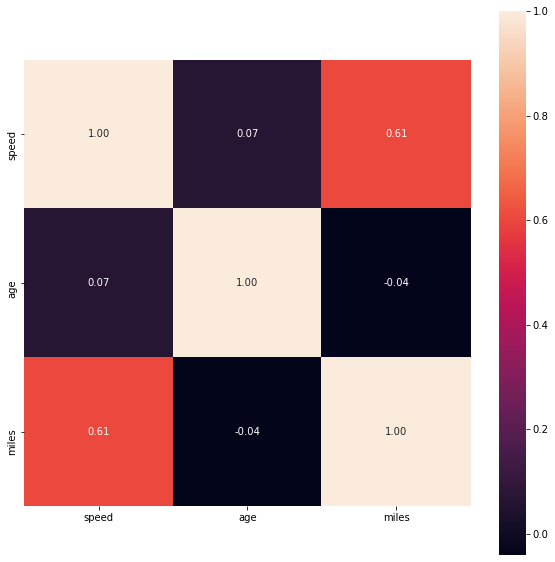

In [17]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:3, :3]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                yticklabels=vars,
                xticklabels=vars)

# Step 2: Training a neural network on 2 dimensions of the data

In [18]:
y = df['group'].values
# add more columns to list to have fewer features to train on
X = df.drop(['risk', 'group', 'miles'], axis='columns').values
# reorder, first age, then speed to match plotting
X = pd.DataFrame(np.array([X[:, 1], X[:, 0]]).T)
X.shape, y.shape

((1500, 2), (1500,))

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 2), (300, 2), (1200,), (300,))

In [39]:
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)

y_train = tf.expand_dims(tf.convert_to_tensor(y_train), axis=1)
y_val = tf.expand_dims(tf.convert_to_tensor(y_val), axis=1)

In [42]:
X_train.shape, y_train.shape

(TensorShape([1200, 2]), TensorShape([1200, 1]))

In [169]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.6
model = tf.keras.Sequential()

model.add(InputLayer(name='input', input_shape=(num_features,)))

model.add(Dense(500, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))
base_model = model

# Wrap the model with adversarial regularization.
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)

model = adv_model

base_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation_20 (Activation)   (None, 500)               0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 500)               2000      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_21 (Activation)   (None, 500)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 500)               2000      
_________________________________________________________________
output (Dense)               (None, 3)               

In [170]:
%%time 

BATCH_SIZE = 32
EPOCHS = 100

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit({'input': X_train, 'label': y_train},
#                     validation_data={'input': X_val, 'label': y_val},
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 33.6 s, sys: 12.5 s, total: 46.2 s
Wall time: 31.6 s


In [171]:
loss, scaled_adversarial_loss, accuracy, sparse_categorical_crossentropy = model.evaluate({'input': X_train, 'label': y_train}, batch_size=BATCH_SIZE)
accuracy

38/38 [==============================] - 0s 4ms/step - loss: 0.8254 - sparse_categorical_crossentropy: 0.6872 - sparse_categorical_accuracy: 0.7092 - scaled_adversarial_loss: 0.1382


0.7091666460037231

In [172]:
loss, scaled_adversarial_loss, accuracy, sparse_categorical_crossentropy = model.evaluate({'input': X_val, 'label': y_val}, batch_size=BATCH_SIZE)
accuracy

10/10 [==============================] - 0s 4ms/step - loss: 0.8378 - sparse_categorical_crossentropy: 0.6976 - sparse_categorical_accuracy: 0.6900 - scaled_adversarial_loss: 0.1403


0.6899999976158142

In [173]:
base_model.predict([[48, 100]])

array([[0.02084741, 0.08241232, 0.89674026]], dtype=float32)

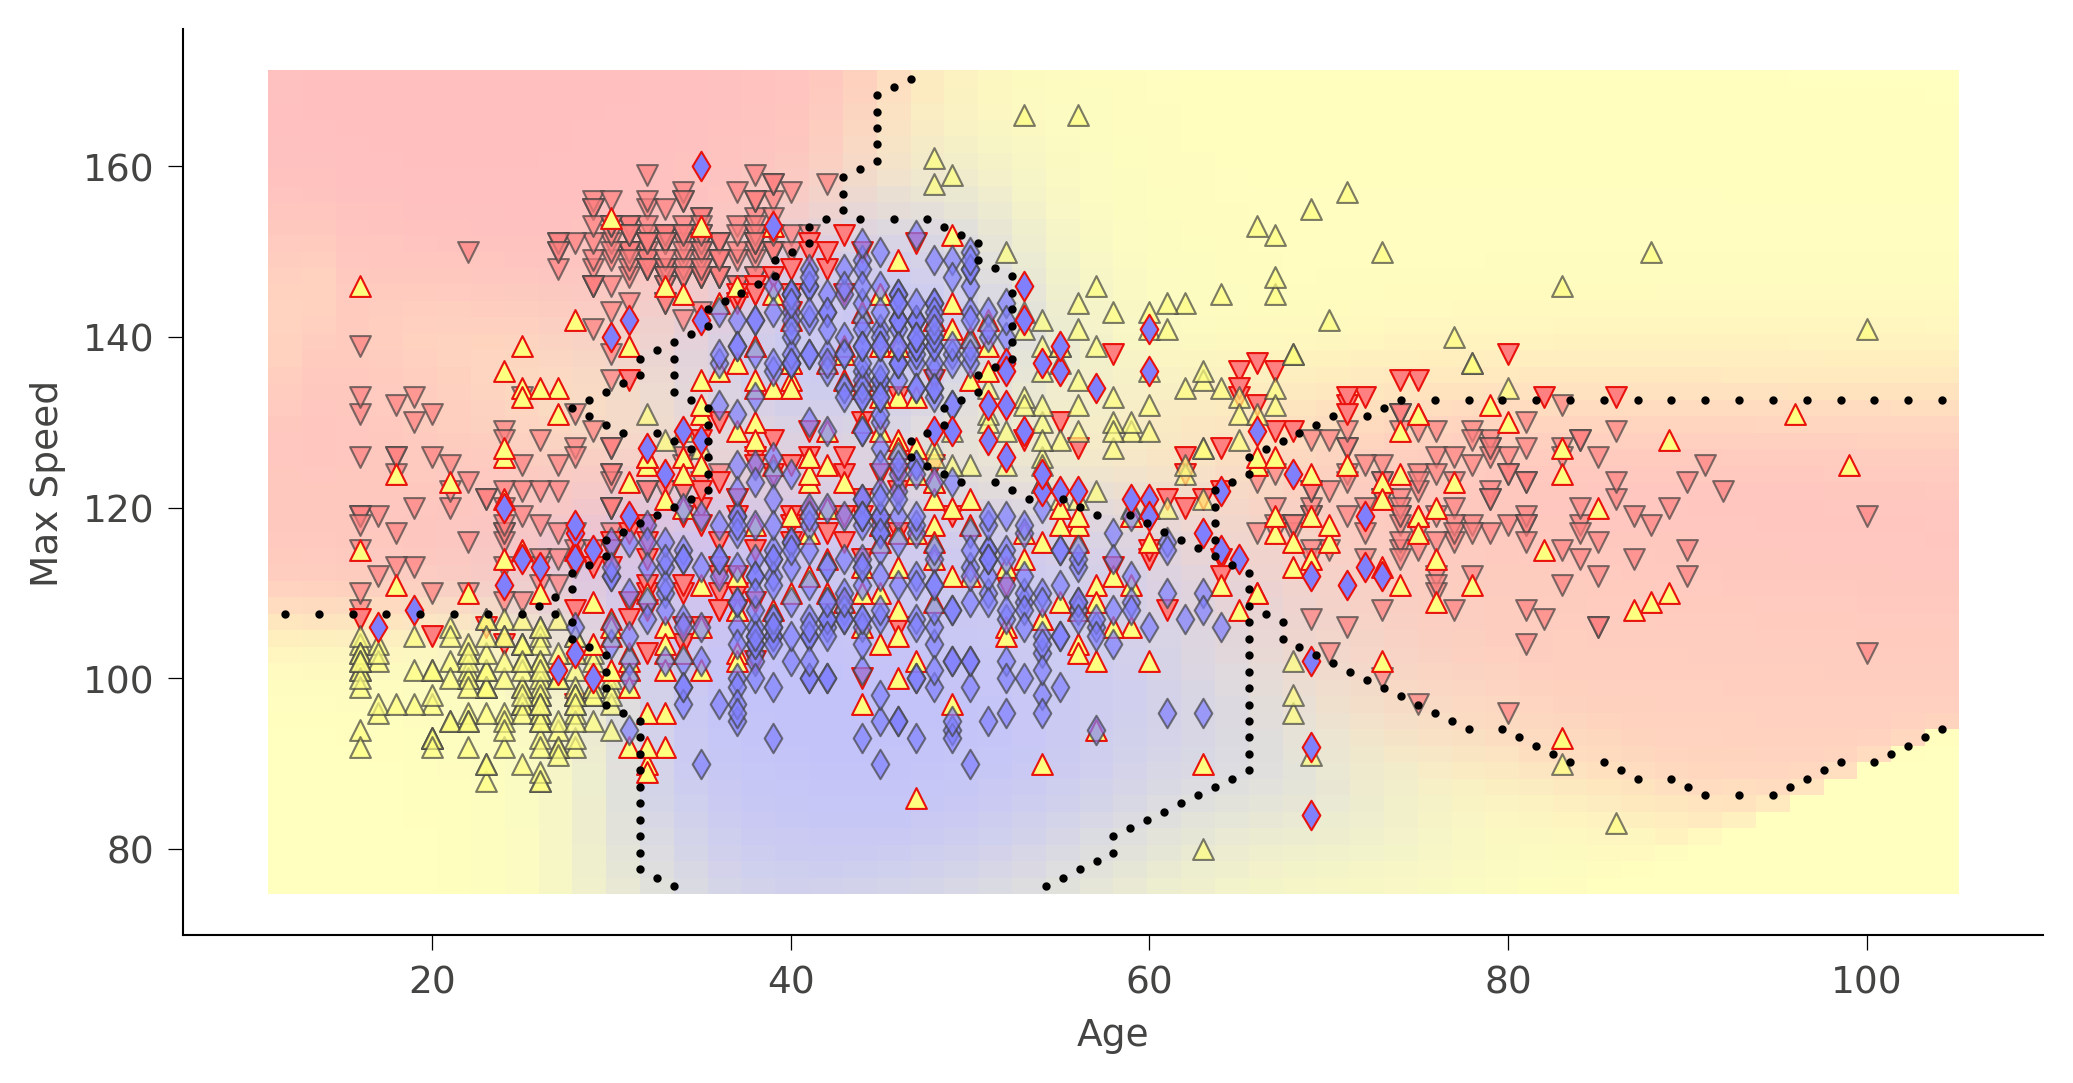

In [174]:
plot_decision_boundaries(base_model, X, y)

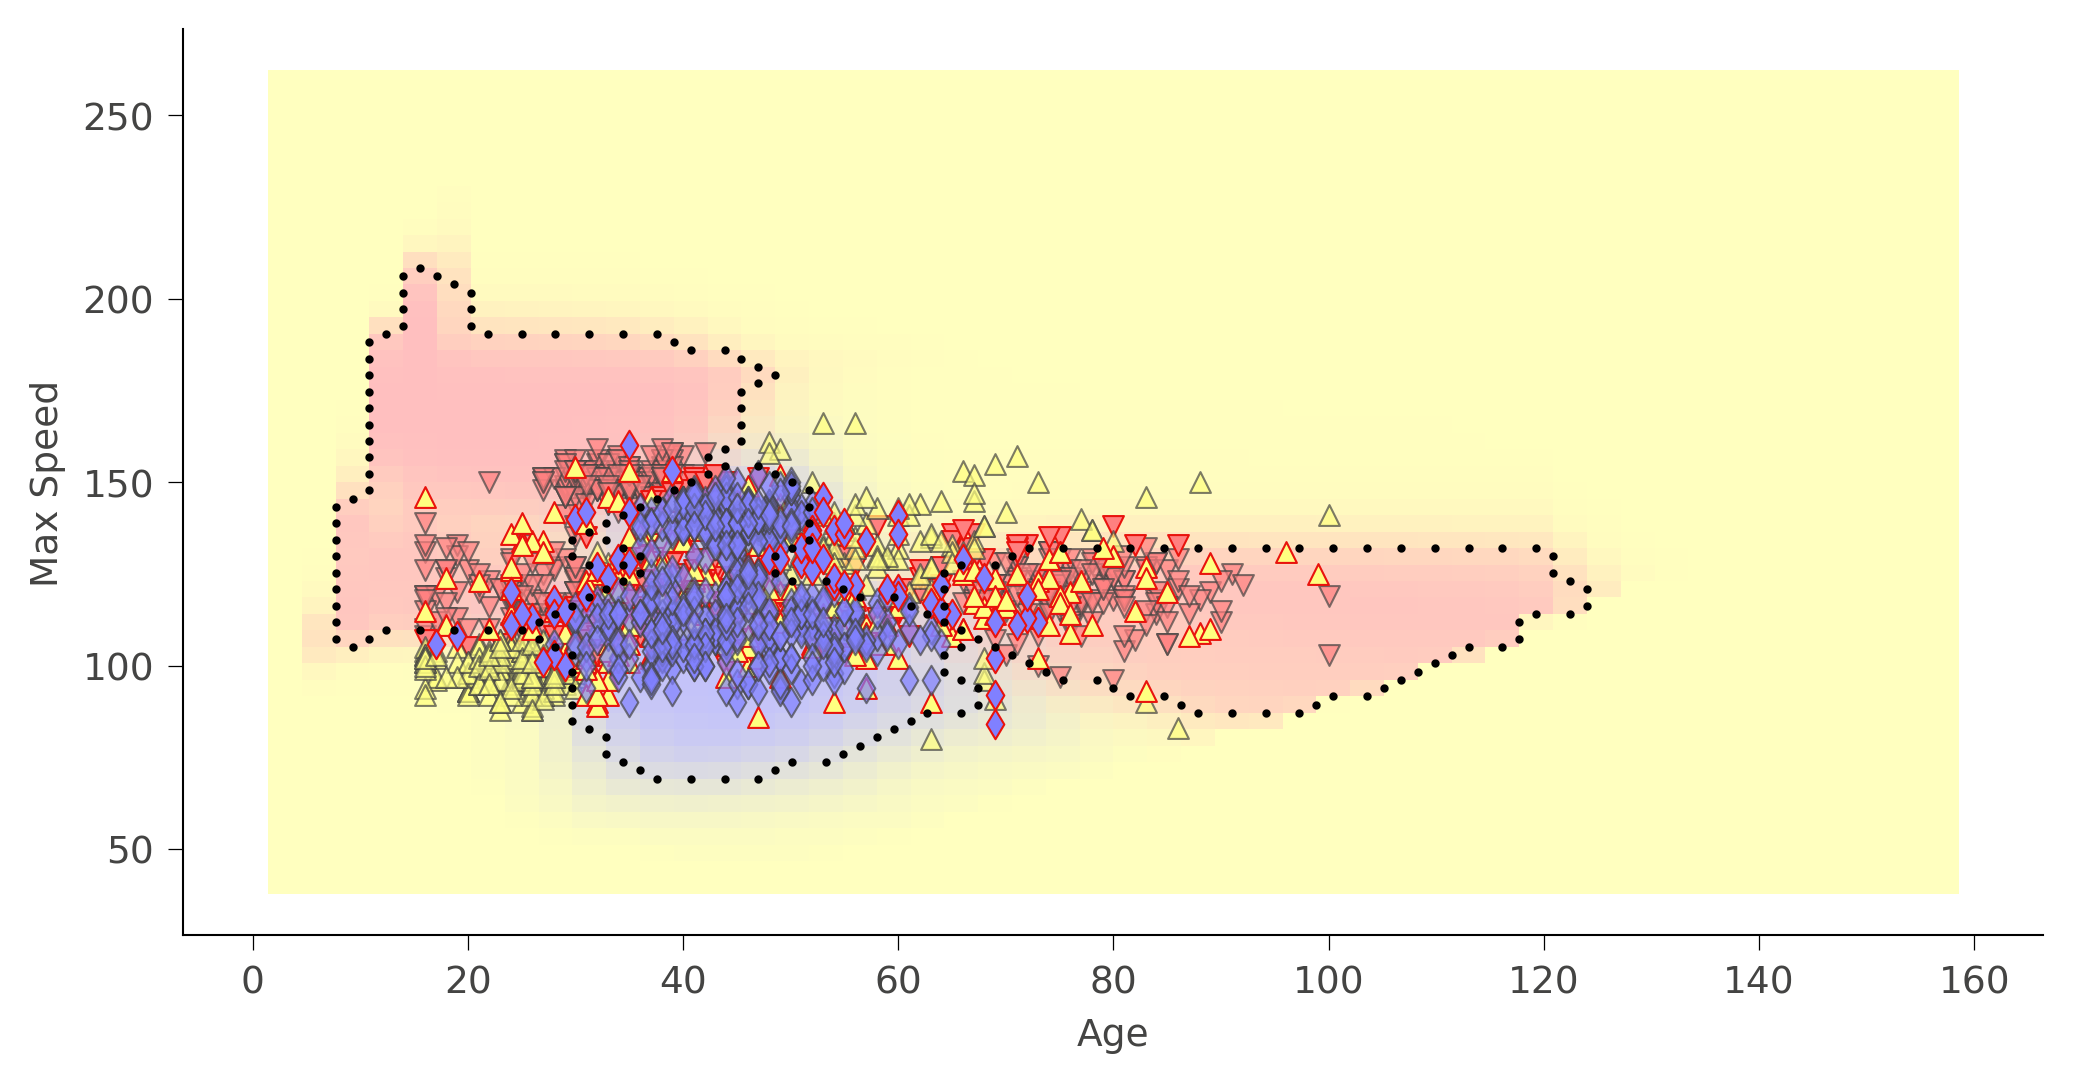

In [175]:
plot_decision_boundaries(base_model, X, y, x1_range=(10, 150), x2_range=(50, 250))
# plot_decision_boundaries(base_model, X, y)